[View in Colaboratory](https://colab.research.google.com/github/SwapnilSParkhe/FAST_AI/blob/master/FASTAI_Lesson3.ipynb)

#Fast.ai Course  
## Lesson-3: Structured and time series data - Rossman Stores (Kaggle)

Note: Leveraging Deepl Learning Models to work with Time Series Data based Predictions

### Step-0: Calibrate platforms (Setting-up compatibile interface btwn Colab & fast.ai) 

Note: Run for each unique instance of connection 

**Imp: Check if GPU running and what % of GPU is available (>500MB RAM worked)**

In [1]:
#Check if GPU running
import tensorflow as tf
print(tf.test.gpu_device_name())

#Libraries and code to check % GPU free for you for this runtime
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
#FACT: Only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

/device:GPU:0
  Running setup.py bdist_wheel for gputil ... - done
  Stored in directory: /content/.cache/pip/wheels/17/0f/04/b79c006972335e35472c0b835ed52bfc0815258d409f560108
Successfully built gputil
  Running setup.py bdist_wheel for humanize ... - done
  Stored in directory: /content/.cache/pip/wheels/69/86/6c/f8b8593bc273ec4b0c653d3827f7482bb2001a2781a73b7f44
Successfully built humanize
Gen RAM Free: 11.9 GB  | Proc size: 1.0 GB
GPU RAM Free: 564MB | Used: 10875MB | Util  95% | Total 11439MB


**Installing required and dependent libraries on Colab for fast.ai**

In [0]:
#FASTAI lib (use this to remove '!rm -rf fastai')
!pip install fastai

#FASTAI dependencies - LibSim lib (Pytorch installed below)
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python

#IMPORTANT STUFF - to enable smooth runs without memory issues
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'
!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision
import torch
print(torch.__version__)
print(torch.cuda.is_available())

#Others libs like Pillow, PIL, Image, cv2 - For image data wrangling
!pip install Pillow==4.0.0
!pip install image
import cv2

### Step-1: Importing relevant libraries and modules for analysis

In [0]:
#Library and modules
from fastai.imports import *   #main library
from fastai.torch_imports import *
from fastai.structured import *
from fastai.dataset import *
from fastai.column_data import *

from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import LabelEncoder, Imputer, StandardScaler
from sklearn.metrics import confusion_matrix
import operator
import os

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#To get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

### Step-2: Download dataset

In [4]:
#Remove directory data if already existing by running "rm -rf data"
#rm -rf data

#Making a new directory and changing working dir to this new dir
!mkdir -p 'rossmann'
os.chdir('rossmann')

#Untarring zipped data to the new created working dir
!wget http://files.fast.ai/part2/lesson14/rossmann.tgz && tar -xvzf rossmann.tgz

--2018-07-18 02:34:43--  http://files.fast.ai/part2/lesson14/rossmann.tgz
Resolving files.fast.ai (files.fast.ai)... 67.205.15.147
Connecting to files.fast.ai (files.fast.ai)|67.205.15.147|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7730448 (7.4M) [text/plain]
Saving to: ‘rossmann.tgz’

rossmann.tgz        100%[===================>]   7.37M  --.-KB/s    in 0.1s    

2018-07-18 02:34:43 (50.1 MB/s) - ‘rossmann.tgz’ saved [7730448/7730448]

googletrend.csv
sample_submission.csv
state_names.csv
store.csv
store_states.csv
test.csv
train.csv
weather.csv


### Step-3: Data Inspection

**Checking Directory Contents and Data**

In [5]:
#Dir content
!ls

googletrend.csv        state_names.csv	 test.csv
rossmann.tgz	       store.csv	 train.csv
sample_submission.csv  store_states.csv  weather.csv


In [6]:
#Peek into the data
table_names = ['train', 'store', 'store_states', 'state_names', 'googletrend', 'weather', 'test']
table_list = [pd.read_csv(f'{fname}.csv', low_memory=False) for fname in table_names]
for table in table_list: display(table.head())

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


,Store,State
0,1,HE
1,2,TH
2,3,NW
3,4,BE
4,5,SN


,StateName,State
0,BadenWuerttemberg,BW
1,Bayern,BY
2,Berlin,BE
3,Brandenburg,BB
4,Bremen,HB


,file,week,trend
0,Rossmann_DE_SN,2012-12-02 - 2012-12-08,96
1,Rossmann_DE_SN,2012-12-09 - 2012-12-15,95
2,Rossmann_DE_SN,2012-12-16 - 2012-12-22,91
3,Rossmann_DE_SN,2012-12-23 - 2012-12-29,48
4,Rossmann_DE_SN,2012-12-30 - 2013-01-05,67


,file,Date,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,...,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees
0,NordrheinWestfalen,2013-01-01,8,4,2,7,5,1,94,87,...,31.0,12.0,4.0,39,26,58.0,5.08,6.0,Rain,215
1,NordrheinWestfalen,2013-01-02,7,4,1,5,3,2,93,85,...,31.0,14.0,10.0,24,16,NaN,0.00,6.0,Rain,225
2,NordrheinWestfalen,2013-01-03,11,8,6,10,8,4,100,93,...,31.0,8.0,2.0,26,21,NaN,1.02,7.0,Rain,240
3,NordrheinWestfalen,2013-01-04,9,9,8,9,9,8,100,94,...,11.0,5.0,2.0,23,14,NaN,0.25,7.0,Rain,263
4,NordrheinWestfalen,2013-01-05,8,8,7,8,7,6,100,94,...,10.0,6.0,3.0,16,10,NaN,0.00,7.0,Rain,268


,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


**Data Inspection Summary**

In [7]:
#Data Frame Summary (its a class based on 'pandas_summary' library)
for table in table_list: display(DataFrameSummary(table).summary())

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
count,1.01721e+06,1.01721e+06,NaN,1.01721e+06,1.01721e+06,1.01721e+06,1.01721e+06,NaN,1.01721e+06
mean,558.43,3.99834,NaN,5773.82,633.146,0.830107,0.381515,NaN,0.178647
std,321.909,1.99739,NaN,3849.93,464.412,0.375539,0.485759,NaN,0.383056
min,1,1,NaN,0,0,0,0,NaN,0
25%,280,2,NaN,3727,405,1,0,NaN,0
50%,558,4,NaN,5744,609,1,0,NaN,0
75%,838,6,NaN,7856,837,1,1,NaN,0
max,1115,7,NaN,41551,7388,1,1,NaN,1
counts,1017209,1017209,1017209,1017209,1017209,1017209,1017209,1017209,1017209
uniques,1115,7,942,21734,4086,2,2,4,2


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
count,1115,NaN,NaN,1112,761,761,1115,571,571,NaN
mean,558,NaN,NaN,5404.9,7.2247,2008.67,0.512108,23.5954,2011.76,NaN
std,322.017,NaN,NaN,7663.17,3.21235,6.19598,0.500078,14.142,1.67494,NaN
min,1,NaN,NaN,20,1,1900,0,1,2009,NaN
25%,279.5,NaN,NaN,717.5,4,2006,0,13,2011,NaN
50%,558,NaN,NaN,2325,8,2010,1,22,2012,NaN
75%,836.5,NaN,NaN,6882.5,10,2013,1,37,2013,NaN
max,1115,NaN,NaN,75860,12,2015,1,50,2015,NaN
counts,1115,1115,1115,1112,761,761,1115,571,571,571
uniques,1115,4,3,654,12,23,2,24,7,3


,Store,State
count,1115,NaN
mean,558,NaN
std,322.017,NaN
min,1,NaN
25%,279.5,NaN
50%,558,NaN
75%,836.5,NaN
max,1115,NaN
counts,1115,1115
uniques,1115,12


,StateName,State
count,16,16
unique,16,16
top,MecklenburgVorpommern,ST
freq,1,1
counts,16,16
uniques,16,16
missing,0,0
missing_perc,0%,0%
types,unique,unique


,file,week,trend
count,NaN,NaN,2072
mean,NaN,NaN,63.8142
std,NaN,NaN,12.6502
min,NaN,NaN,0
25%,NaN,NaN,55
50%,NaN,NaN,64
75%,NaN,NaN,72
max,NaN,NaN,100
counts,2072,2072,2072
uniques,14,148,68


,file,Date,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,...,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees
count,NaN,NaN,15840,15840,15840,15840,15840,15840,15840,15840,...,15459,15459,15459,15840,15840,3604,15840,14667,NaN,15840
mean,NaN,NaN,14.6441,10.389,6.19899,8.58782,6.20581,3.62614,93.6596,74.2829,...,24.0576,12.2398,7.02516,22.7666,11.9722,48.8643,0.831718,5.55131,NaN,175.897
std,NaN,NaN,8.64601,7.37926,6.52639,6.24478,6.08677,6.12839,7.67853,13.4866,...,8.9768,5.06794,4.9806,8.98862,5.87284,13.027,2.51351,1.68771,NaN,101.589
min,NaN,NaN,-11,-13,-15,-14,-15,-73,44,30,...,0,0,0,3,2,21,0,0,NaN,-1
25%,NaN,NaN,8,4,1,4,2,-1,90.75,65,...,14,10,3,16,8,39,0,5,NaN,80
50%,NaN,NaN,15,11,7,9,7,4,94,76,...,31,11,7,21,11,48,0,6,NaN,202
75%,NaN,NaN,21,16,11,13,11,8,100,85,...,31,14,10,27,14,55,0.25,7,NaN,256
max,NaN,NaN,39,31,24,25,20,19,100,100,...,31,31,31,101,53,111,58.93,8,NaN,360
counts,15840,15840,15840,15840,15840,15840,15840,15840,15840,15840,...,15459,15459,15459,15840,15840,3604,15840,14667,11889,15840
uniques,16,990,51,45,40,40,36,40,53,71,...,24,32,24,44,29,47,41,9,21,362


,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
count,41088,41088,41088,NaN,41077,41088,NaN,41088
mean,20544.5,555.9,3.97917,NaN,0.854322,0.395833,NaN,0.443487
std,11861.2,320.274,2.01548,NaN,0.352787,0.489035,NaN,0.496802
min,1,1,1,NaN,0,0,NaN,0
25%,10272.8,279.75,2,NaN,1,0,NaN,0
50%,20544.5,553.5,4,NaN,1,0,NaN,0
75%,30816.2,832.25,6,NaN,1,1,NaN,1
max,41088,1115,7,NaN,1,1,NaN,1
counts,41088,41088,41088,41088,41077,41088,41088,41088
uniques,41088,856,7,48,2,2,2,2


### Step-4: Data Cleaning and Feature Engineering

Note: Even though, we are using DL for solving this problem, performing feature engineering would help us extract some subtle features which would not have been directly tapped upon by our neural network architectures (all this could make our model more rich), for e.g.:

*   Date based factors - month, day of week, etc. (Helps NN to capture trends/cyclical behaviour as a function of time - "The Time Series")
*   External factors - temperature, holiday, major event, and other google trend based info (Helps NN to capture effect of external factors on problem)



**A) Minor manipulations and  modifications**

In [8]:
#Spitting out respectve tables from our table_list
train,store,store_states,state_names,googletrend,weather,test=table_list
print(f'Fraction of train and test is, {round(len(train)/(len(train)+len(test)),2)} and {round(len(test)/(len(train)+len(test)),2)}, respectively')

Fraction of train and test is, 0.96 and 0.04, respectively


*Train and test tables*

In [0]:
#Turning StateHolidays column (in train & test) to boolean - convenient 
##Note: This column had 4 levels but collapsing it (True is holiday)
train['StateHoliday']=train['StateHoliday']!='0'
test['StateHoliday']=test['StateHoliday']!='0'

#Extracting date-based columns (Applying FAST.AI's add_datepart function)
##Note: 'drop=False' retais the original date column
add_datepart(train,"Date",drop=False)
add_datepart(test,"Date",drop=False)

*Googletrend table*

In [0]:
#Extracting date for start of the week (Applying str.split method)
##Note: 'expand=True' expands split info into columns - easier to access
googletrend['Date']=googletrend['week'].str.split(' - ',expand=True)[0]

#Extracting state from file (Applying str.split method)
googletrend['State']=googletrend['file'].str.split('_',expand=True)[2]

#Extracting date-based columns (Applying FAST.AI's add_datepart function)
add_datepart(googletrend,"Date",drop=False)

#Extracting info 'Rossmann_DE' (overall germany) and creating a new table 
trend_de=googletrend[googletrend['file']=='Rossmann_DE']

*Weather table*

In [0]:
#Extracting date-based columns (Applying FAST.AI's add_datepart function)
add_datepart(weather,"Date",drop=False)

**B) Joining tables**

In [0]:
#Utility function for joining dfs more conveniently
def join_df(left, right, left_on, right_on=None, suffix="_y"):
  if right_on is None: right_on=left_on
  return left.merge(right, left_on=left_on, right_on=right_on, suffixes=("",suffix))

In [13]:
#Store-store_states (checking if there was any unmatched value in right_t)
store=join_df(store,store_states,"Store")
#Weather-state_names
weather=join_df(weather,state_names,'file','StateName')

sum(store['State'].isnull()),sum(weather['State'].isnull())

(0, 0)

In [14]:
#(Train,test)-store (checking if there was any unmatched value in right_t)
##Note: Level of store table is "Store"
joined=join_df(train,store,"Store")
joined_test=join_df(test,store,"Store")
sum(joined['State'].isnull()),sum(joined_test['State'].isnull())

(0, 0)

In [15]:
#Joined(train,test)-googletrend for states(checking if there was any unmatched value in right_t)
##Note: Level of googletrend table for states is "State-Year-Week"
joined=join_df(joined,googletrend,["State","Year","Week"])
joined_test=join_df(joined_test,googletrend,["State","Year","Week"])
sum(joined['trend'].isnull()),sum(joined_test['trend'].isnull())

(0, 0)

In [16]:
#Joined(train,test)-googletrend for germany (checking if there was any unmatched value in right_t)
##Note: Level of googletrend table for germany is "Year-Week"
joined=join_df(joined,trend_de,["Year","Week"],suffix='_DE')
joined_test=join_df(joined_test,trend_de,["Year","Week"],suffix='_DE')
sum(joined['trend_DE'].isnull()),sum(joined_test['trend_DE'].isnull())

(0, 0)

In [17]:
#Joined(train,test)-weather (checking if there was any unmatched value in right_t)
##Note: Level of weather data is "State-Date"
joined=join_df(joined,weather,["State","Date"])
joined_test=join_df(joined_test,weather,["State","Date"])
sum(joined['Max_TemperatureC'].isnull()),sum(joined_test['Max_TemperatureC'].isnull())

(0, 0)

In [0]:
#Dropping duplicated columns created while joinng tables
for df in (joined, joined_test):
    for c in df.columns:
        if c.endswith('_y'):
            if c in df.columns: df.drop(c, inplace=True, axis=1)

**C) Missing Value Treatment**

In [19]:
#Checking columns with missing values (to impute)
x=DataFrameSummary(joined).summary()
x.loc['missing'][x.loc['missing']>0]

#Looking for a descent value imputation (OpenSince related)
print('\n')
joined.filter(like='Comp', axis=1).min()
joined.filter(like='Promo', axis=1).min()

CompetitionDistance            2642
CompetitionOpenSinceMonth    313928
CompetitionOpenSinceYear     313928
Promo2SinceWeek              487307
Promo2SinceYear              487307
PromoInterval                487307
State_DE                     996485
Max_VisibilityKm              24491
Mean_VisibilityKm             24491
Min_VisibilitykM              24491
Max_Gust_SpeedKm_h           766302
CloudCover                    79351
Events                       238420
Name: missing, dtype: object

CompetitionDistance            20.0
CompetitionOpenSinceMonth       1.0
CompetitionOpenSinceYear     1900.0
dtype: float64

Promo                 0.0
Promo2                0.0
Promo2SinceWeek       1.0
Promo2SinceYear    2009.0
dtype: float64

In [0]:
#Imputing values
for df in (joined, joined_test):
  df['CompetitionOpenSinceMonth']= df['CompetitionOpenSinceMonth'].fillna(1).astype(np.int32)
  df['CompetitionOpenSinceYear']= df['CompetitionOpenSinceYear'].fillna(1900).astype(np.int32)
  df['Promo2SinceWeek']=df['Promo2SinceWeek'].fillna(1).astype(np.int32)
  df['Promo2SinceYear']=df['Promo2SinceYear'].fillna(2009).astype(np.int32)

**D) Creating Features**

*Comptetion*

In [0]:
#Creating more sensible and consumable feature => time since competion is open
for df in (joined,joined_test):
  df['CompetitionOpenSince']=pd.to_datetime(dict(year=df['CompetitionOpenSinceYear'],
                                                month=df['CompetitionOpenSinceMonth'],
                                                day=15))
  df['CompetitionDaysOpen']=df['Date'].subtract(df['CompetitionOpenSince']).dt.days

{'boxes': [<matplotlib.lines.Line2D at 0x7fcc92e09358>],
 'caps': [<matplotlib.lines.Line2D at 0x7fcc92e2f3c8>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fcca9d40908>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7fcc92e3f208>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7fcc92e091d0>,
  <matplotlib.lines.Line2D at 0x7fcc92e2fc88>]}

{'boxes': [<matplotlib.lines.Line2D at 0x7fcc92e82e48>],
 'caps': [<matplotlib.lines.Line2D at 0x7fcc92e5eda0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fcc92dbd518>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7fcc92e9ac18>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7fcc92e82400>,
  <matplotlib.lines.Line2D at 0x7fcc92e5e198>]}

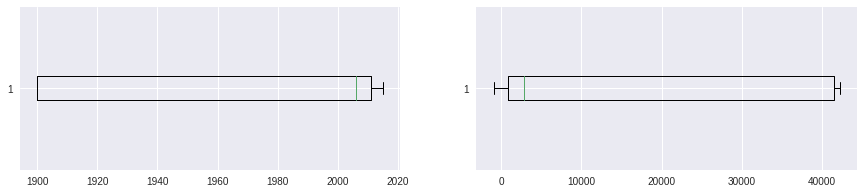

In [22]:
#Checking spread of created vars
fig,ax=plt.subplots(1,2,figsize=(15,3))
ax[0].boxplot(joined['CompetitionOpenSinceYear'],vert=False)
ax[1].boxplot(joined['CompetitionDaysOpen'],vert=False)

In [0]:
#Clipping outliers/wierd values (Conditional Imputation)
for df in (joined, joined_test):
  df.loc[df['CompetitionDaysOpen']<0,'CompetitionDaysOpen']=0
  df.loc[df['CompetitionOpenSinceYear']<1900,'CompetitionDaysOpen']=0

In [24]:
#Creating CompetionMonthsOpen and limiting to 2 years (to limit unique catgs)
for df in (joined, joined_test):
  df['CompetitionMonthsOpen']=df['CompetitionDaysOpen']//30
  df.loc[df['CompetitionMonthsOpen']>24,'CompetitionMonthsOpen']=24
joined['CompetitionMonthsOpen'].unique()   

array([24,  7, 12, 15,  1, 16,  3,  0, 11, 20, 23, 17,  9,  2,  8,  4, 10, 13, 22,  5, 14,  6, 21, 19, 18])

*Promo Dates*

In [0]:
#Creating more sensible and consumable features => time since promotion
for df in (joined, joined_test):
  df['Promo2Since']=pd.to_datetime(df.apply(lambda x: Week(x['Promo2SinceYear'],x['Promo2SinceWeek']).monday(),axis=1).astype(pd.datetime))
  df['Promo2Days']=df['Date'].subtract(df['Promo2Since']).dt.days

{'boxes': [<matplotlib.lines.Line2D at 0x7fcc92e694a8>],
 'caps': [<matplotlib.lines.Line2D at 0x7fcc92e69cc0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fcc92e7af60>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7fcc92e7a828>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7fcc92e695f8>,
  <matplotlib.lines.Line2D at 0x7fcc92e69c18>]}

{'boxes': [<matplotlib.lines.Line2D at 0x7fcc92dab780>],
 'caps': [<matplotlib.lines.Line2D at 0x7fcc92da9940>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fcc92da5320>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7fcc92da5da0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7fcc92dab4e0>,
  <matplotlib.lines.Line2D at 0x7fcc92da9b00>]}

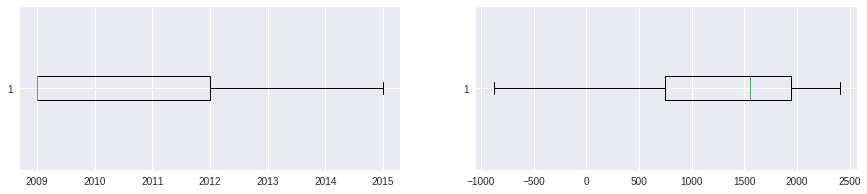

In [26]:
#Checking spread of created vars
fig,ax=plt.subplots(1,2,figsize=(15,3))
ax[0].boxplot(joined['Promo2SinceYear'],vert=False)
ax[1].boxplot(joined['Promo2Days'],vert=False)

In [27]:
#Clipping outliers/wierd values (Conditional Imputation)
#Creating Promo2Weeks and limiting to 2 years (to limit unique catgs)
for df in (joined,joined_test):
    df.loc[df['Promo2Days']<0, "Promo2Days"] = 0
    df.loc[df['Promo2SinceYear']<1990, "Promo2Days"] = 0
    
    df["Promo2Weeks"] = df["Promo2Days"]//7
    df.loc[df['Promo2Weeks']<0, "Promo2Weeks"] = 0
    df.loc[df['Promo2Weeks']>25, "Promo2Weeks"] = 25
    df['Promo2Weeks'].unique()

array([25,  8, 17, 13,  7, 16, 12, 24,  6, 15, 11, 23,  5, 14, 10, 22,  4,  9, 21,  3, 20,  2, 19,  1, 18,
        0])

array([25, 15, 24, 20, 14, 23, 19, 13, 22, 18, 12, 21, 17, 11, 16, 10,  9,  8])

**E) Saving ADS (to fast accessible 'feather' format)**

In [0]:
joined.to_feather('joined')
joined_test.to_feather('joined_test')

**F) Creating features that would taps into relationship across rows (for Time Series info)**
  
 1. Time until and since - next and event last event respectively
 3. Running averages



In [0]:
#Utility function for cumulative days counting at a group-level (store-flag) using dates column
def get_elapsed(field, prefix):
  #Initialising
  day1=np.timedelta64(1,'D')
  last_date=np.datetime64()
  last_store=0
  result=[]
  
  #iterating row-by-row w.r.t three arrays (zipped together)
  for s,v,d in zip(df['Store'].values, df[field].values, df['Date'].values):
    if s!=last_store: #iterting through first column till new value found
      last_date=np.datetime64() 
      last_store=s
    if v: #for flag=True else keep on iterating
      last_date=d #initiates to (NaN if v=False and new_store) else (same date if same_store and v=False) else (new date if same/new_store and v=True)
    result.append((d-last_date).astype('timedelta64[D]')/day1)
  df[prefix+field]=result
  
#Columns to focus on with this
columns = ["Date", "Store", "Promo", "StateHoliday", "SchoolHoliday"]
df=train[columns]
df=test[columns]

In [0]:
#1. Time until and since last event
columns = ["Promo", "StateHoliday", "SchoolHoliday"]
for event in columns:
  df = df.sort_values(['Store', 'Date']) 
  get_elapsed(event, 'After')  #days since last respective event
  df = df.sort_values(['Store', 'Date'], ascending=[True, False]) 
  get_elapsed(event, 'Before')  #days til next respective event
  
#Missing Value Treatment - Imputing with 0
for prefix in ['After', 'Before']:
  for c in columns:
    col=prefix+c
    df[col]=df[col].fillna(0).astype(int)

In [0]:
#2. Running averages - First counting events/flags of interest in bwd and fwd diretions
df=df.set_index('Date')
bwd = df[['Store']+columns].sort_index().groupby("Store")[columns].rolling(7, min_periods=1).sum()
fwd = df[['Store']+columns].sort_index(ascending=False).groupby('Store')[columns].rolling(7,min_periods=1).sum()

In [87]:
#Preparing for merge btwn 1&2 with main table (Getting key cols ready)
df.reset_index(inplace=True)  #'Date' is req for join
bwd.reset_index(inplace=True)  #'Store' is req for join
fwd.reset_index(inplace=True)  #'Store' is req for join

#Merging 1&2 with main table
df = df.merge(bwd, 'left', ['Date','Store'],suffixes=['','_bw'])
df = df.merge(fwd, 'left', ['Date','Store'],suffixes=['', '_fw'])
df.drop(columns,axis=1,inplace=True)  #Dropping derived but raw columns
df.head(5)

,Date,Store,AfterPromo,BeforePromo,AfterStateHoliday,BeforeStateHoliday,AfterSchoolHoliday,BeforeSchoolHoliday,Promo_bw,StateHoliday_bw,SchoolHoliday_bw,Promo_fw,StateHoliday_fw,SchoolHoliday_fw
0,2015-09-17,1,0,0,0,0,13,0,4.0,0.0,0.0,1.0,0.0,0.0
1,2015-09-16,1,0,0,0,0,12,0,3.0,0.0,0.0,2.0,0.0,0.0
2,2015-09-15,1,0,0,0,0,11,0,2.0,0.0,0.0,3.0,0.0,0.0
3,2015-09-14,1,0,0,0,0,10,0,1.0,0.0,0.0,4.0,0.0,0.0
4,2015-09-13,1,9,-1,0,0,9,0,0.0,0.0,0.0,4.0,0.0,0.0


**G) Saving to RAM (for back-up) & joining with main tables or ADS**

In [0]:
#Saving and reading
df.to_feather('df')
df = pd.read_feather('df')

#Joining to main tables/ADS
##Note: Level of df is Store-Date (so join at that for correctness)
df['Date']=pd.to_datetime(df['Date'])
joined = join_df(joined, df, ['Store', 'Date'])
joined_test = join_df(joined_test, df, ['Store', 'Date'])

#Formatting - Removing rows with -ve Sales (as per problem defn) & Resetting index
joined = joined[joined.Sales!=0]
joined.reset_index(inplace=True)
joined_test.reset_index(inplace=True)

#Saving and reading
joined.to_feather('joined')
joined_test.to_feather('joined_test')

### Step-5: Training Model 

In [62]:
bwd.head()

Promo  StateHoliday  SchoolHoliday
Store Date                                          
1     2015-08-01    0.0           0.0            1.0
      2015-08-02    0.0           0.0            2.0
      2015-08-03    1.0           0.0            3.0
      2015-08-04    2.0           0.0            4.0
      2015-08-05    3.0           0.0            5.0

In [68]:
bwd.head()

Store  Promo  StateHoliday  SchoolHoliday
Store Date                                                 
1     2015-08-01    1.0    0.0           0.0            1.0
      2015-08-02    2.0    0.0           0.0            2.0
      2015-08-03    3.0    1.0           0.0            3.0
      2015-08-04    4.0    2.0           0.0            4.0
      2015-08-05    5.0    3.0           0.0            5.0